In [1]:
import numpy as np
import pandas as pd
from glob import glob
import pydicom

In [2]:
PATH = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
axis_move = {'sagittal': 0, 'coronal': 1, 'axial': 2}

In [3]:
def read_dicom_files(cohort, case, mpMRI):
    files_glob = f'{PATH}/{cohort}/{case}/{mpMRI}/*.dcm'
    sorted_files = sorted(glob(files_glob),key=lambda f: int(f.split('Image-')[1].split('.')[0]))
    return [pydicom.read_file(f) for f in sorted_files]

def image_orientation(dicom):
    rt = 'unkown'
    # https://www.kaggle.com/davidbroberts/determining-mr-image-planes
    (x1,y1,_,x2,y2,_) = [round(v) for v in dicom.ImageOrientationPatient]
    if (x1,y1,x2,y2) == (1,0,0,0):
        rt = 'coronal'
    if (x1,y1,x2,y2) == (1,0,0,1):
        rt = 'axial'
    if (x1,y1,x2,y2) == (0,1,0,0):
        rt = 'sagittal'
    
    if rt == 'unkown':
        raise ValueError(f'unkown ImageOrientationPatient: {dicom.ImageOrientationPatient}')
        
    return rt

def stats_images(images):
    pixels = images.ravel()
    noncero_pixels = pixels[np.nonzero(pixels)]
    mean = np.mean(noncero_pixels) # <-- collect 
    std = np.std(noncero_pixels) # <-- collect 
    return (mean,std)

def top_brilliant_image(images, mean, std):
    level = mean + 3*std
    non_cero_pixels = np.count_nonzero(np.reshape(images, (images.shape[0],-1)) > level,  axis=1)
    top_image = np.argsort(non_cero_pixels)[::-1][0]
    return top_image

def top_brilliant_line(image, mean, std, axis):
    non_cero_pixels = np.count_nonzero(image > mean+3*std,  axis=axis)
    top_line = np.argsort(non_cero_pixels)[::-1][0]
    return top_line

def normalize_image(image, mean, std):
    return (image-mean)/std

def calc_center(dicom_file, r, c):
    orientation = image_orientation(dicom_file)
    if orientation == 'coronal':
        center = [dicom_file.ImagePositionPatient[0] + dicom_file.PixelSpacing[0] * c,
                  dicom_file.ImagePositionPatient[1],
                  dicom_file.ImagePositionPatient[2] - dicom_file.PixelSpacing[1] * r]

    if orientation == 'sagittal':
        center = [dicom_file.ImagePositionPatient[0],
                  dicom_file.ImagePositionPatient[1] + dicom_file.PixelSpacing[0] * c,
                  dicom_file.ImagePositionPatient[2] - dicom_file.PixelSpacing[1] * r]
        
    if orientation == 'axial':
        center = [dicom_file.ImagePositionPatient[0] + dicom_file.PixelSpacing[0] * c,
                  dicom_file.ImagePositionPatient[1] + dicom_file.PixelSpacing[0] * r,
                  dicom_file.ImagePositionPatient[2]]

    return center

def find_nearest_scan(dicom_files, center):
    orientation = image_orientation(dicom_files[0])
    a = np.array([f.ImagePositionPatient for f in dicom_files])
    scan = np.argsort(np.abs(a - center),axis=0)[0][axis_move[orientation]]
    return scan

In [4]:
cohort = 'train'
case = '00581'

# To Do: review cases 00266, 00457, 00611, 00631
#   - case 00266 vs 00737

flair_dicom_files = read_dicom_files(cohort, case, 'FLAIR')
t1w_dicom_files = read_dicom_files(cohort, case, 'T1w')
t1wce_dicom_files = read_dicom_files(cohort, case, 'T1wCE')
t2w_dicom_files = read_dicom_files(cohort, case, 'T2w')

In [5]:
flair_orientation = image_orientation(flair_dicom_files[0])
flair_nscans = len(flair_dicom_files)
t1w_orientation = image_orientation(t1w_dicom_files[0])
t1w_nscans = len(t1w_dicom_files)
t1wce_orientation = image_orientation(t1wce_dicom_files[0])
t1wce_nscans = len(t1wce_dicom_files)
t2w_orientation = image_orientation(t2w_dicom_files[0])
t2w_nscans = len(t2w_dicom_files)

In [6]:
print(f"FLAIR: {flair_orientation}, {flair_nscans} scans")
print(f"T1w: {t1w_orientation}, {t1w_nscans} scans")
print(f"T1wce: {t1wce_orientation}, {t1wce_nscans} scans")
print(f"T2w: {t2w_orientation}, {t2w_nscans} scans")

FLAIR: axial, 80 scans
T1w: sagittal, 22 scans
T1wce: axial, 124 scans
T2w: axial, 80 scans


In [7]:
(flair_dicom_files[0].PatientID,t1w_dicom_files[0].PatientID,t1wce_dicom_files[0].PatientID,t2w_dicom_files[0].PatientID)

('00581', '00581', '00581', '00581')

In [8]:
flair_images = np.array([s.pixel_array for s in flair_dicom_files])
#-- tiw_images = np.array([s.pixel_array for s in t1w_dicom_files])


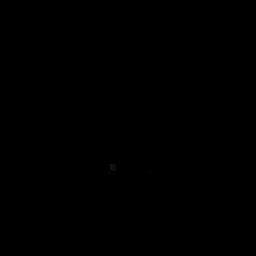
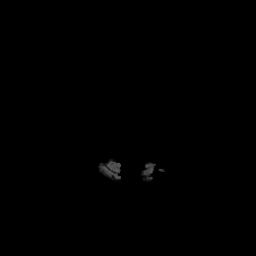
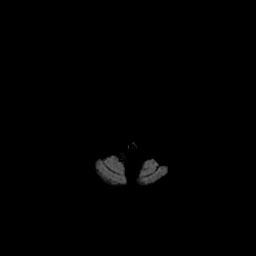
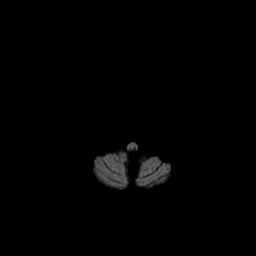
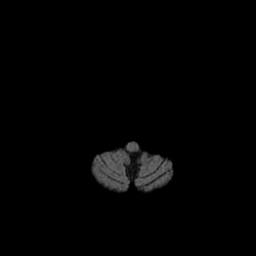
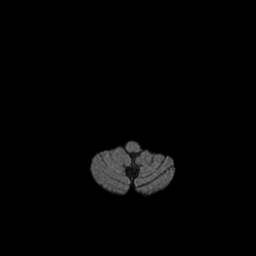
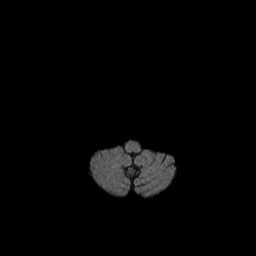
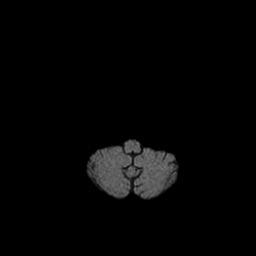
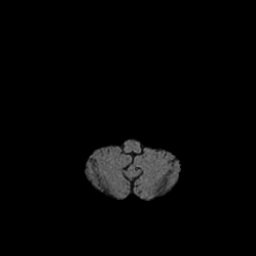
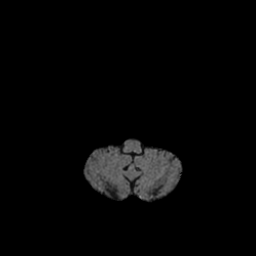
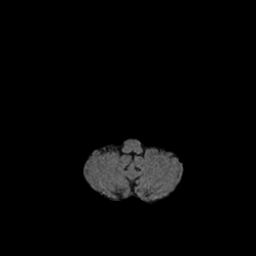
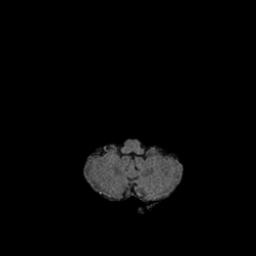
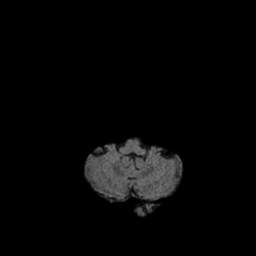
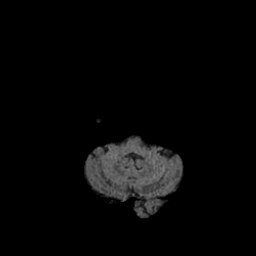
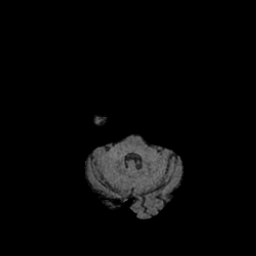
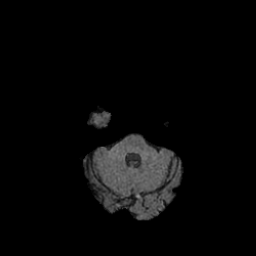
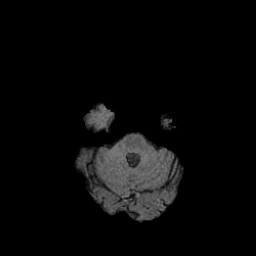
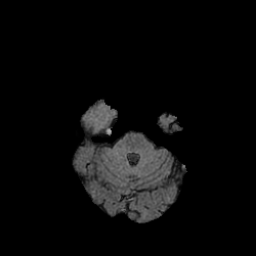
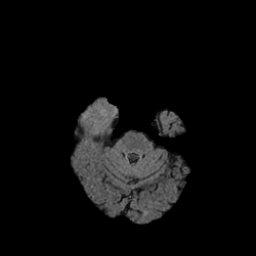
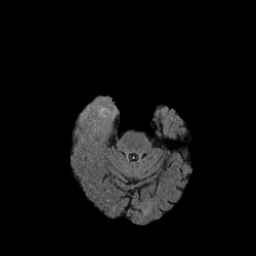
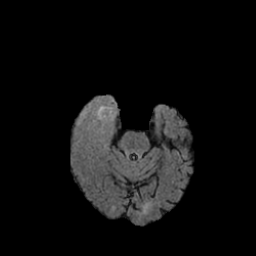
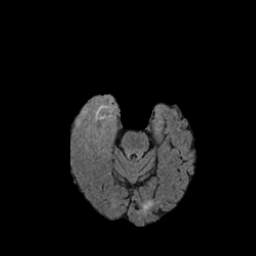
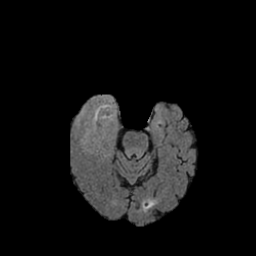
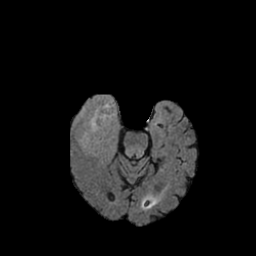
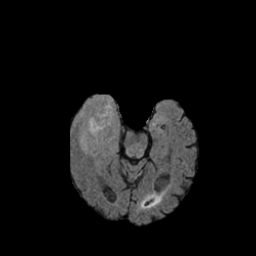
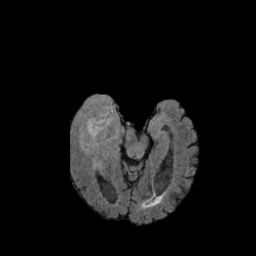
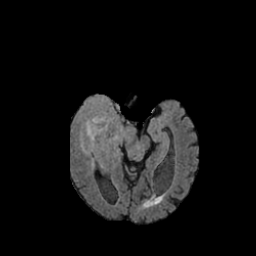
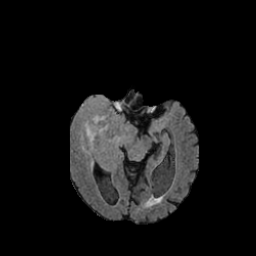
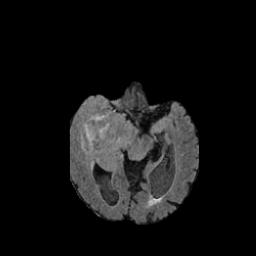
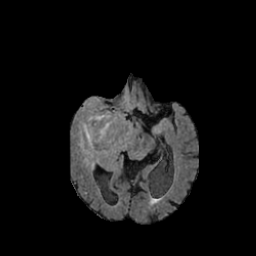
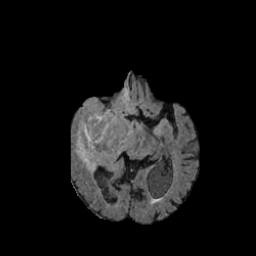
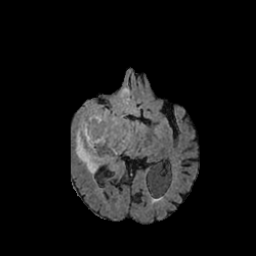
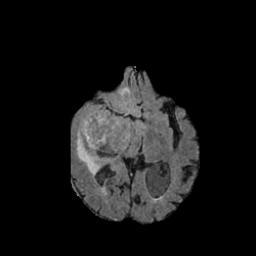
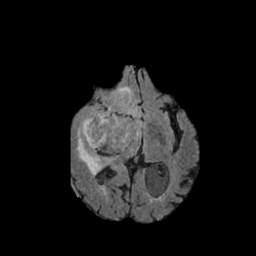
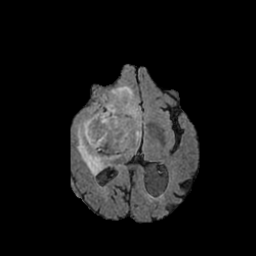
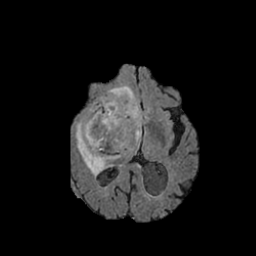
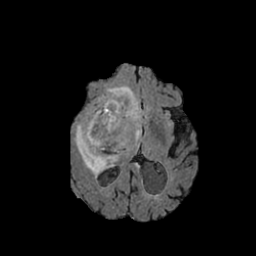
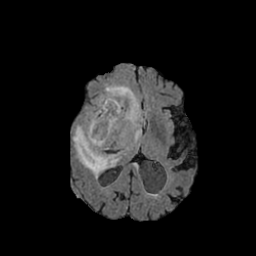
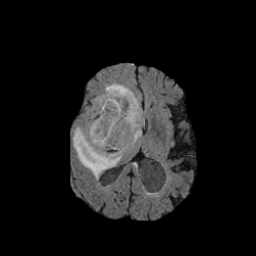
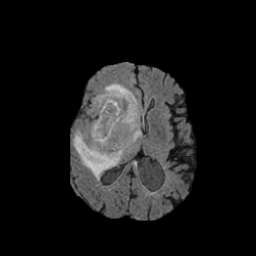
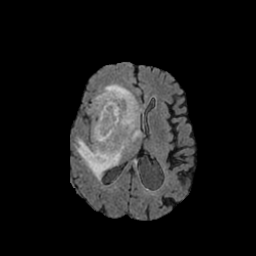
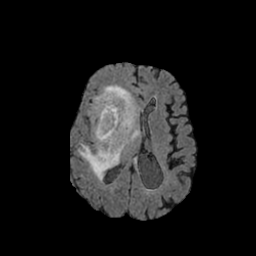
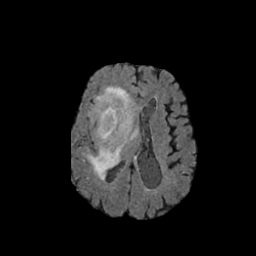
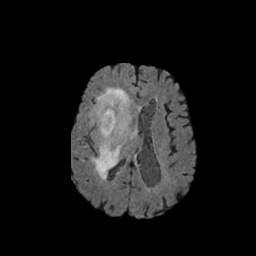
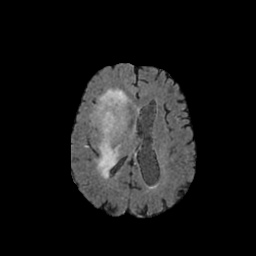
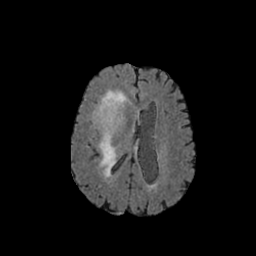
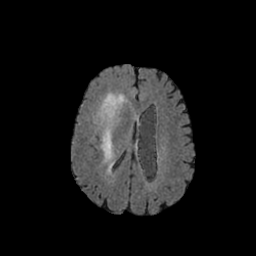
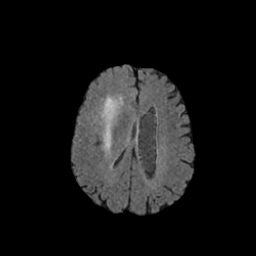
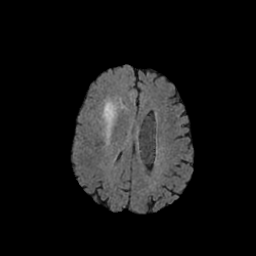
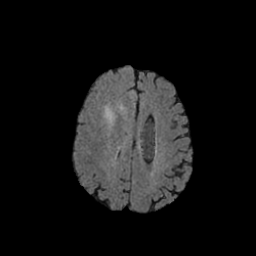
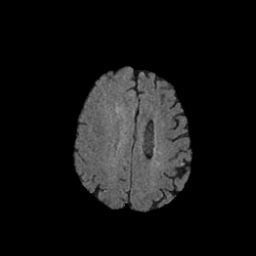
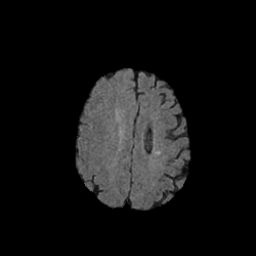
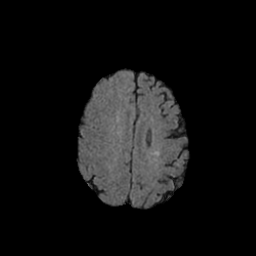
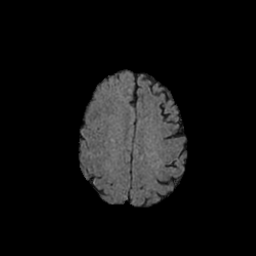
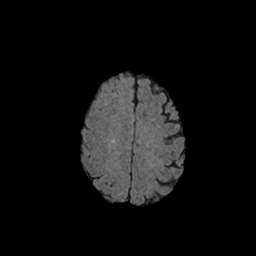
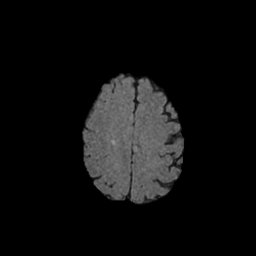
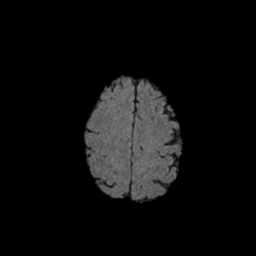
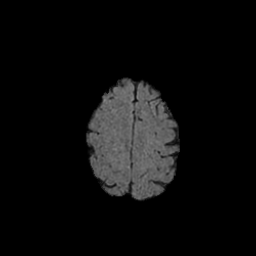
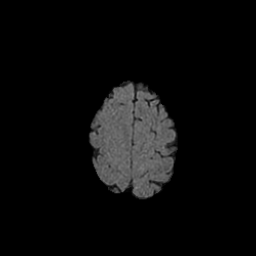
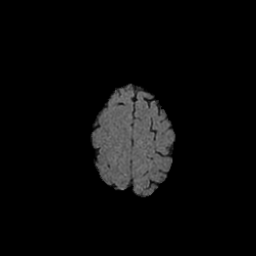
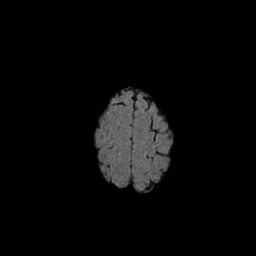
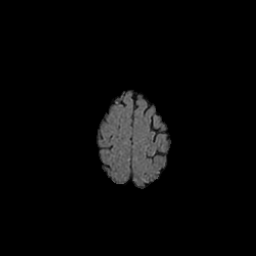
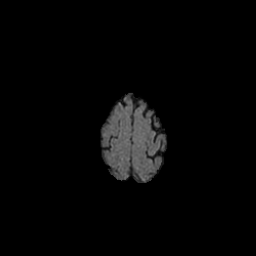
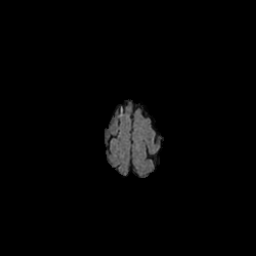
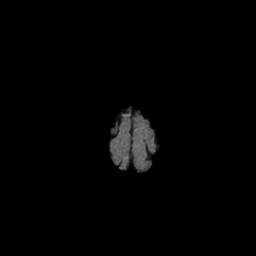
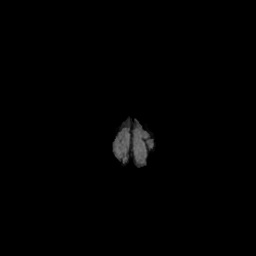
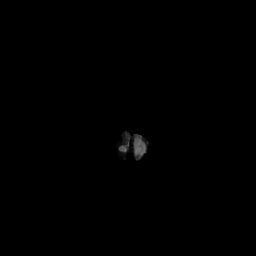
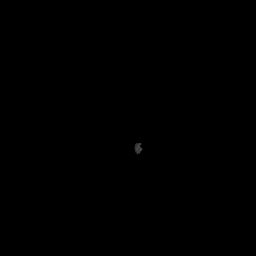

In [9]:
import plotly.express as px

fig = px.imshow(flair_images, animation_frame=0, binary_string=True, labels=dict(animation_frame="scan"), height=800)
fig.show()

In [10]:
(min,max)=(flair_images.min(), flair_images.max()) # <-- collect / normalize

[187] 169.6742761160992 62.81472420767073


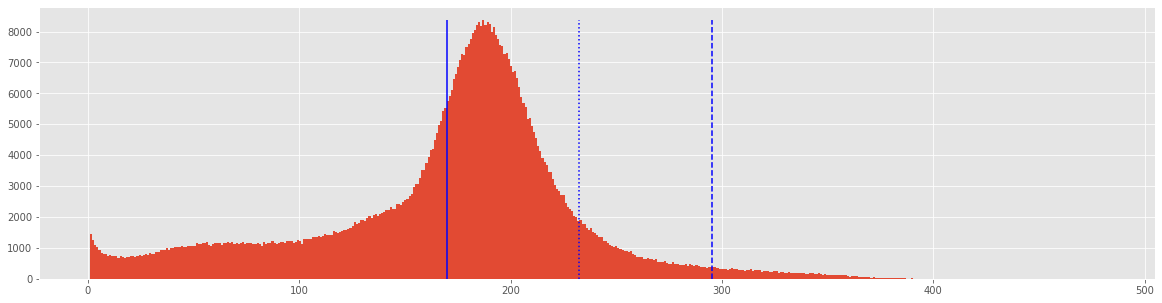

In [11]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from scipy import stats
plt.style.use('ggplot')


a=flair_images.ravel()
a=a[np.nonzero(a)]
mode = stats.mode(a)

(mean,std) = stats_images(flair_images)
print(mode.mode, mean, std)

pixels = flair_images.ravel()
noncero_pixels = pixels[np.nonzero(pixels)]

plt.figure(figsize = (20,5))
plt.hist(noncero_pixels, max)
plt.vlines(mean, 0, mode.count, colors='b')
plt.vlines(mean+std, 0, mode.count, colors='b', linestyles='dotted')
plt.vlines(mean+2*std, 0, mode.count, colors='b', linestyles='dashed')

plt.show()

In [12]:
top = top_brilliant_image(flair_images, mean, std)
top

44

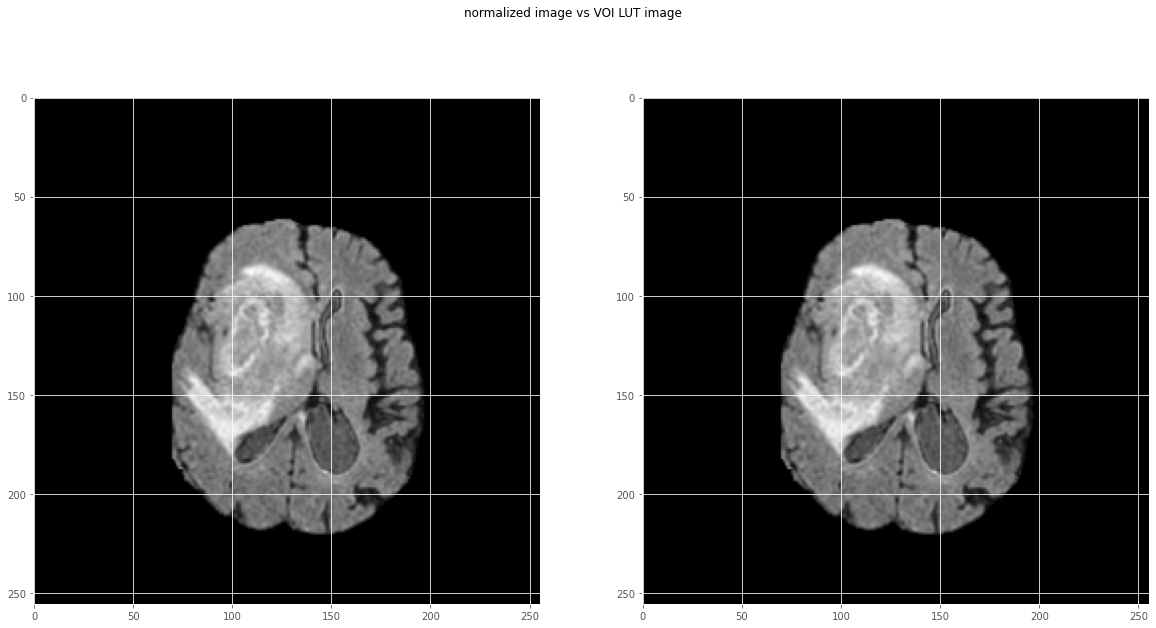

In [13]:
from pydicom.pixel_data_handlers.util import apply_voi_lut

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
fig.suptitle('normalized image vs VOI LUT image')

image = flair_images[top]
image = normalize_image(image, mean, std)
ax1.imshow(image, cmap = plt.cm.gray)

im = apply_voi_lut(flair_dicom_files[top].pixel_array, flair_dicom_files[top])
ax2.imshow(im, cmap = plt.cm.gray)

plt.show()

In [14]:
(top,flair_dicom_files[top].ImagePositionPatient)

(44, [-125, -136.7097473, 24.5901337])

In [15]:
rtop = top_brilliant_line(flair_images[top], mean, std, axis=1)
ctop = top_brilliant_line(flair_images[top], mean, std, axis=0)

(rtop,ctop)

(88, 101)

In [16]:
flair_dicom_files[top]

Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.36548896702150287088418507832671027890
(0008, 0050) Accession Number                    SH: '00581'
(0008, 0060) Modality                            CS: 'MR'
(0008, 103e) Series Description                  LO: 'FLAIR'
(0010, 0010) Patient's Name                      PN: '00581'
(0010, 0020) Patient ID                          LO: '00581'
(0018, 0023) MR Acquisition Type                 CS: '2D'
(0018, 0050) Slice Thickness                     DS: "2.0"
(0018, 0081) Echo Time                           DS: None
(0018, 0082)

In [17]:
center = calc_center(flair_dicom_files[top], rtop, ctop)

center

[-26.363400876522036, -50.76894806370237, "24.5901337"]

In [18]:
scan_t1wce = find_nearest_scan(t1wce_dicom_files, center)
(t1wce_orientation, scan_t1wce, t1wce_dicom_files[scan_t1wce].ImagePositionPatient)

('axial', 68, [-125, -136.7097473, 24.3858662])

In [19]:
scan_t1w = find_nearest_scan(t1w_dicom_files, center)
(t1w_orientation, scan_t1w, t1w_dicom_files[scan_t1w].ImagePositionPatient)

('sagittal', 16, [-26.24882507, -124.5882111, 130])

In [20]:
scan_t2w = find_nearest_scan(t2w_dicom_files, center)
(t2w_orientation, scan_t2w, t2w_dicom_files[scan_t2w].ImagePositionPatient)

('axial', 44, [-125, -136.7097473, 24.5901337])

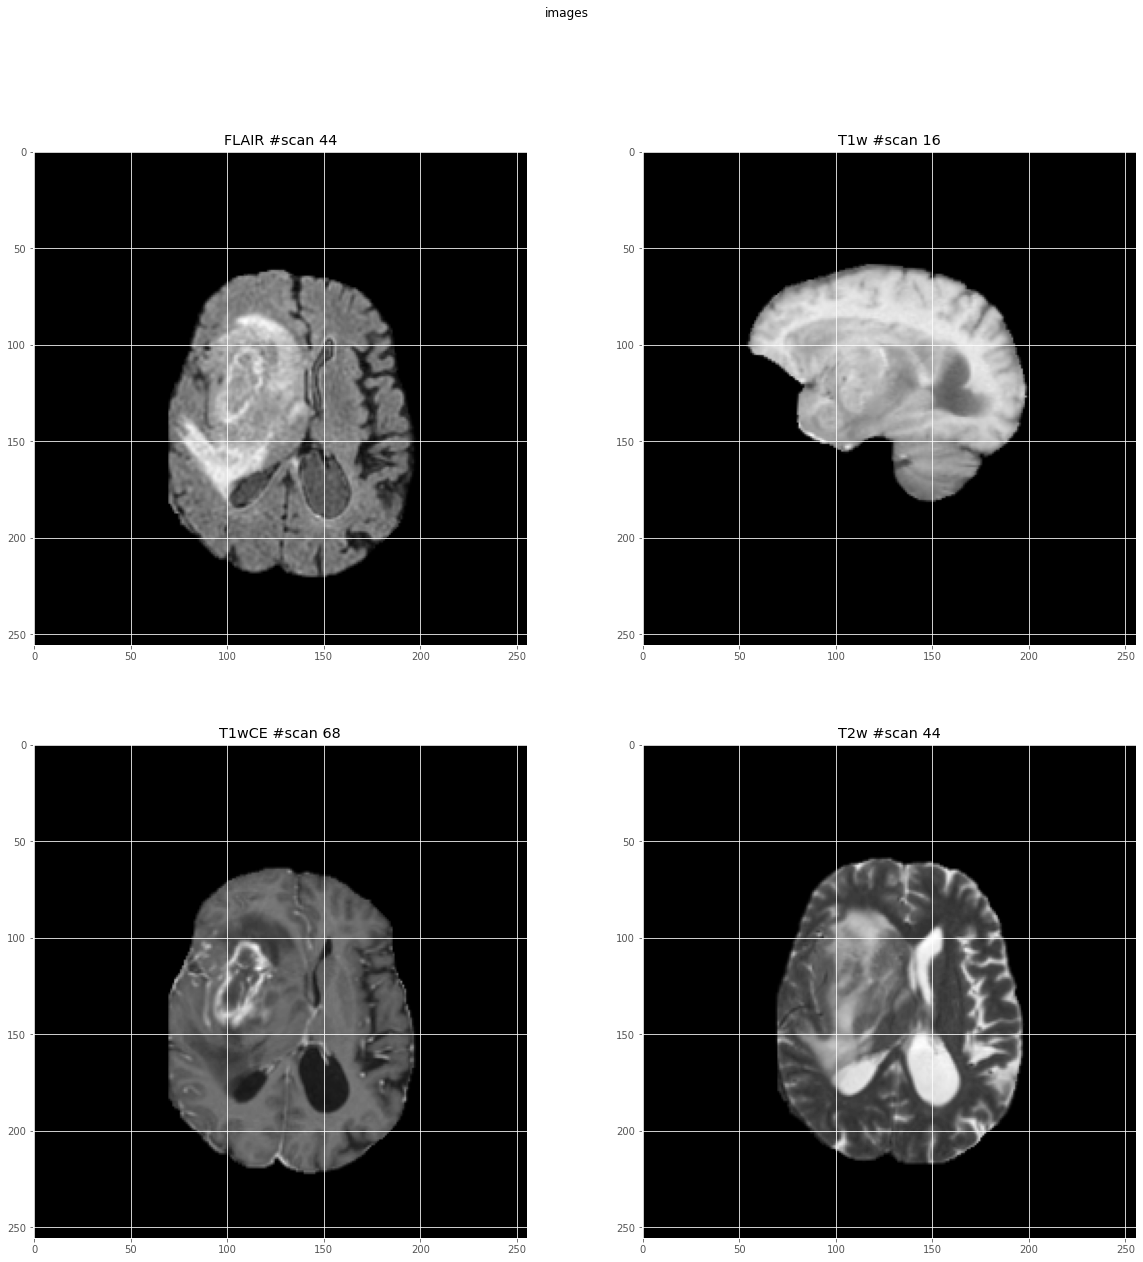

In [21]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (20,20))
fig.suptitle('images')

im = apply_voi_lut(flair_dicom_files[top].pixel_array, flair_dicom_files[top])
ax1.imshow(im, cmap = plt.cm.gray)
ax1.set_title(f'FLAIR #scan {top}')

im = apply_voi_lut(t1w_dicom_files[scan_t1w].pixel_array, t1w_dicom_files[scan_t1w])
ax2.imshow(im, cmap = plt.cm.gray)
ax2.set_title(f'T1w #scan {scan_t1w}')

im = apply_voi_lut(t1wce_dicom_files[scan_t1wce].pixel_array, t1wce_dicom_files[scan_t1wce])
ax3.imshow(im, cmap = plt.cm.gray)
ax3.set_title(f'T1wCE #scan {scan_t1wce}')

im = apply_voi_lut(t2w_dicom_files[scan_t2w].pixel_array, t2w_dicom_files[scan_t2w])
ax4.imshow(im, cmap = plt.cm.gray)
ax4.set_title(f'T2w #scan {scan_t2w}')

plt.show()

In [22]:
def process_case_and_plot(cohort, case):
    flair_dicom_files = read_dicom_files(cohort, case, 'FLAIR')
    t1w_dicom_files = read_dicom_files(cohort, case, 'T1w')
    t1wce_dicom_files = read_dicom_files(cohort, case, 'T1wCE')
    t2w_dicom_files = read_dicom_files(cohort, case, 'T2w')
    
    flair_images = np.array([s.pixel_array for s in flair_dicom_files])
    (mean,std) = stats_images(flair_images)
    
    top = top_brilliant_image(flair_images, mean, std)
    rtop = top_brilliant_line(flair_images[top], mean, std, axis=1)
    ctop = top_brilliant_line(flair_images[top], mean, std, axis=0)

    center = calc_center(flair_dicom_files[top], rtop, ctop)
    
    flair_image = normalize_image(flair_images[top], mean, std)
    
    scan_t1w = find_nearest_scan(t1w_dicom_files, center)
    scan_t1wce = find_nearest_scan(t1wce_dicom_files, center)
    scan_t2w = find_nearest_scan(t2w_dicom_files, center)

    t1w_images = np.array([s.pixel_array for s in t1w_dicom_files])
    (mean,std) = stats_images(t1w_images)
    t1w_image = normalize_image(t1w_images[scan_t1w], mean, std)
    
    t1wce_images = np.array([s.pixel_array for s in t1wce_dicom_files])
    (mean,std) = stats_images(t1wce_images)
    t1wce_image = normalize_image(t1wce_images[scan_t1wce], mean, std)
    
    t2w_images = np.array([s.pixel_array for s in t2w_dicom_files])
    (mean,std) = stats_images(t2w_images)
    t2w_image = normalize_image(t2w_images[scan_t2w], mean, std)

    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize = (20,5))
    fig.suptitle(f'Case {case}')
    
    ax1.imshow(flair_image, cmap = plt.cm.gray)
    ax1.set_title(f'FLAIR #scan {top}')
    ax1.grid(False)

    ax2.imshow(t1w_image, cmap = plt.cm.gray)
    ax2.set_title(f'T1w #scan {scan_t1w}')
    ax2.grid(False)
    
    ax3.imshow(t1wce_image, cmap = plt.cm.gray)
    ax3.set_title(f'T1wCE #scan {scan_t1wce}')
    ax3.grid(False)

    ax4.imshow(t2w_image, cmap = plt.cm.gray)
    ax4.set_title(f'T2w #scan {scan_t2w}')
    ax4.grid(False)

    plt.show()

In [23]:
train = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv', converters = {'BraTS21ID': str,})

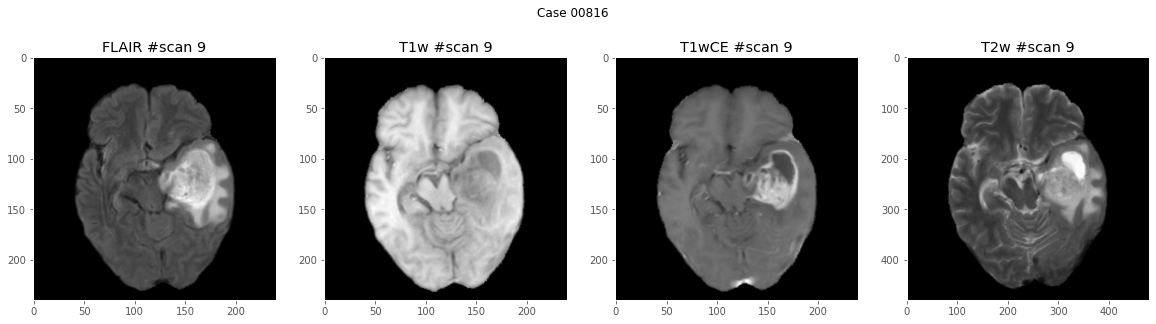

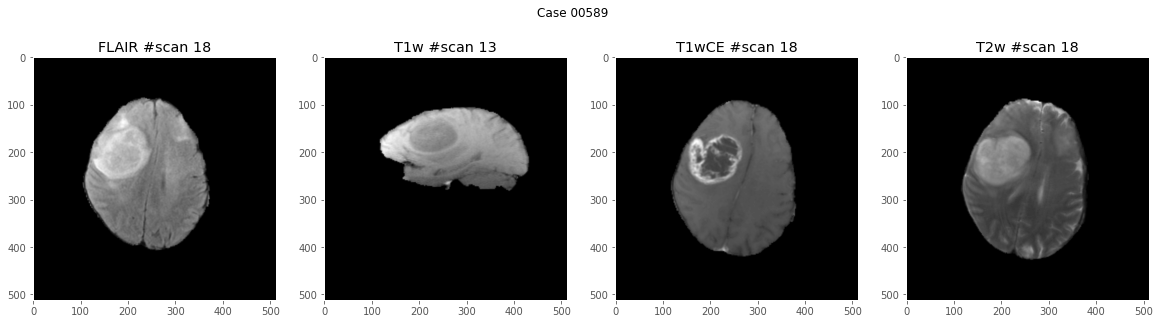

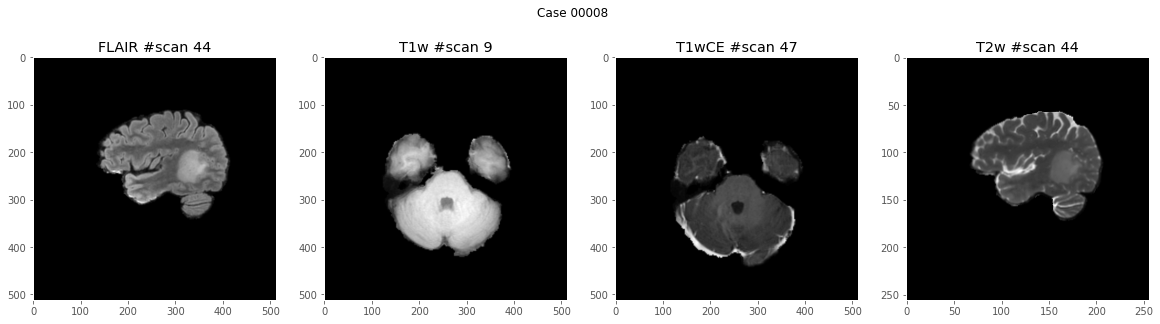

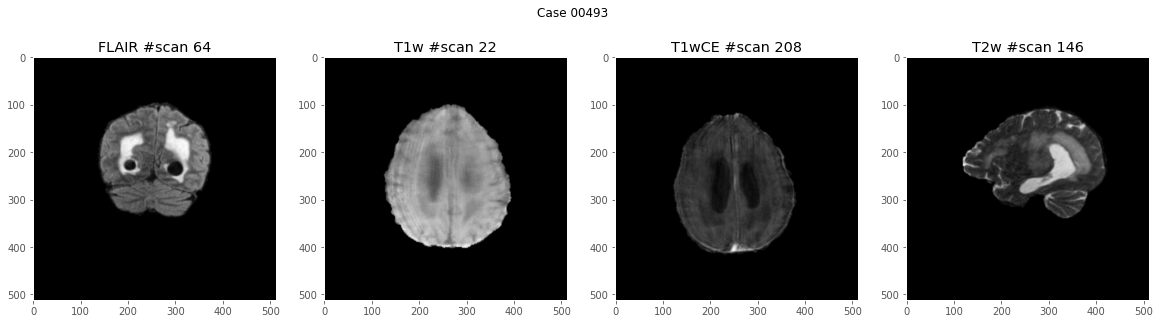

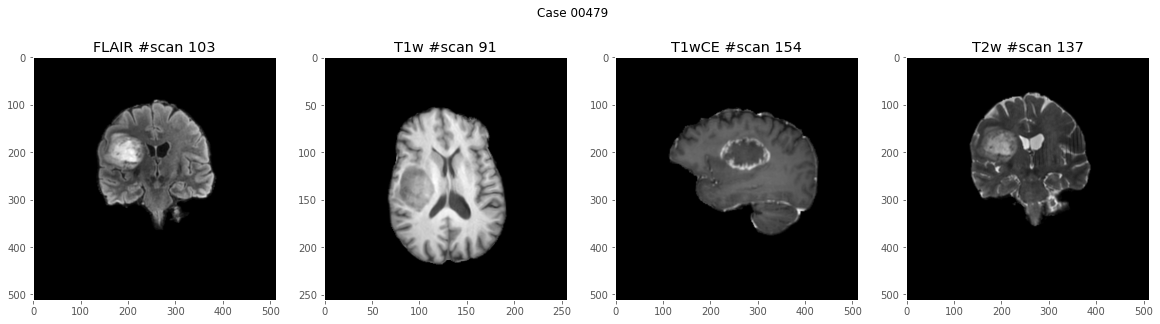

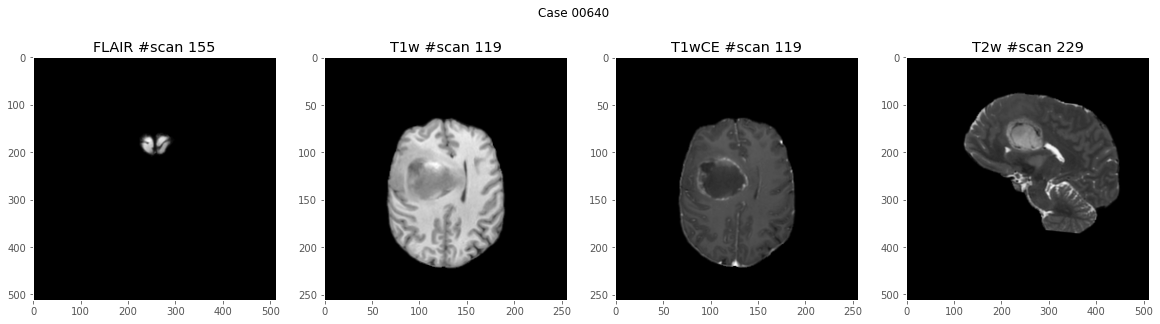

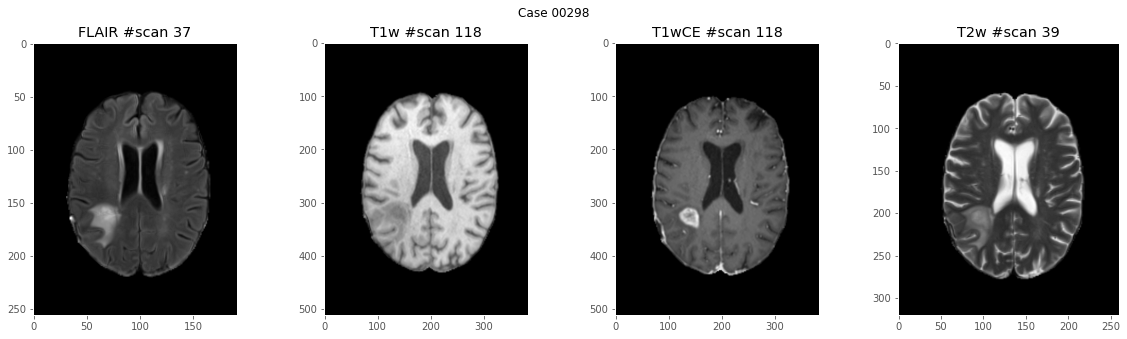

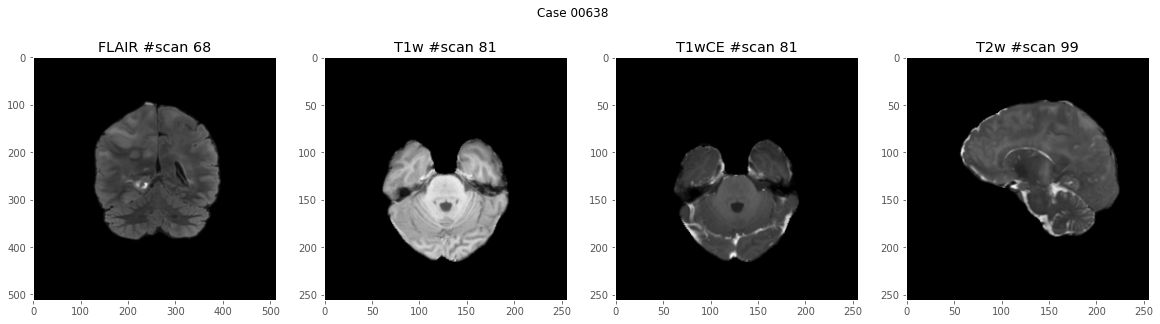

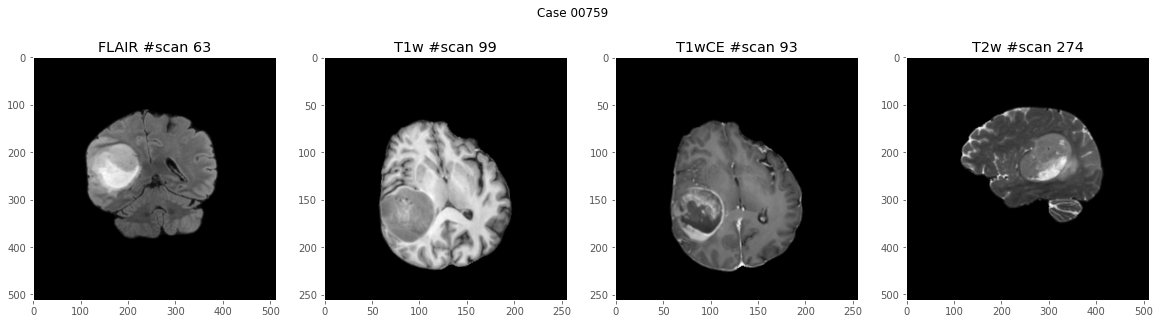

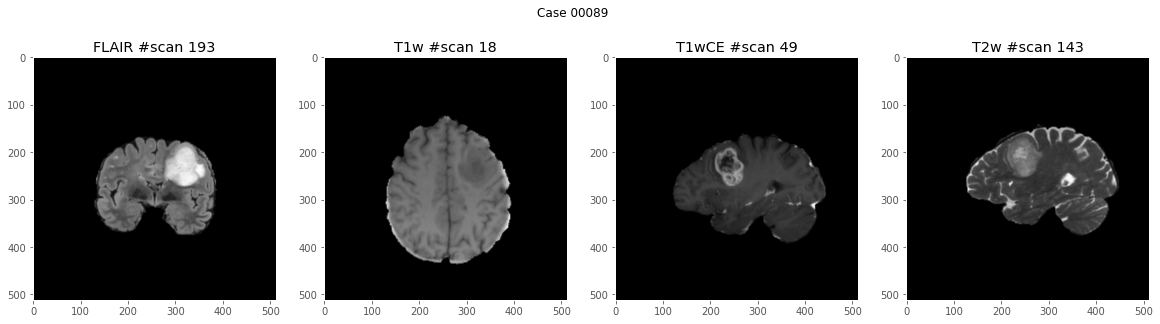

In [24]:
cohort = 'train'
for case in train.sample(10).BraTS21ID:  
    process_case_and_plot(cohort, case)

In [25]:
test = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv', converters = {'BraTS21ID': str,})

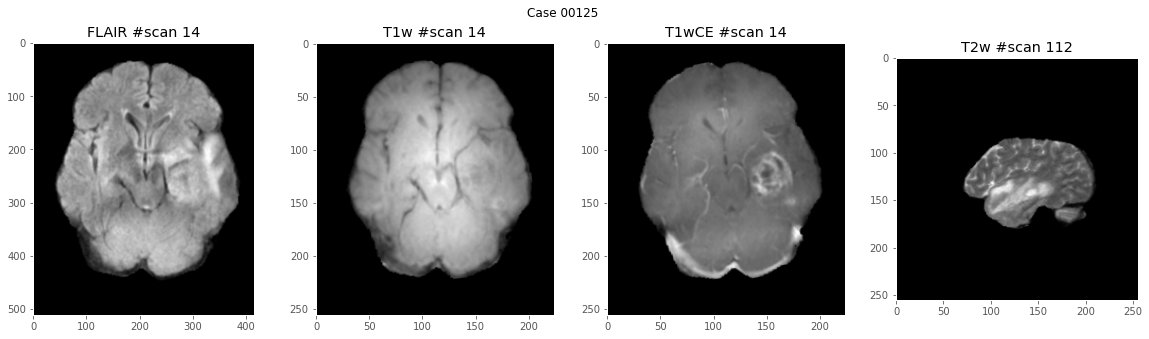

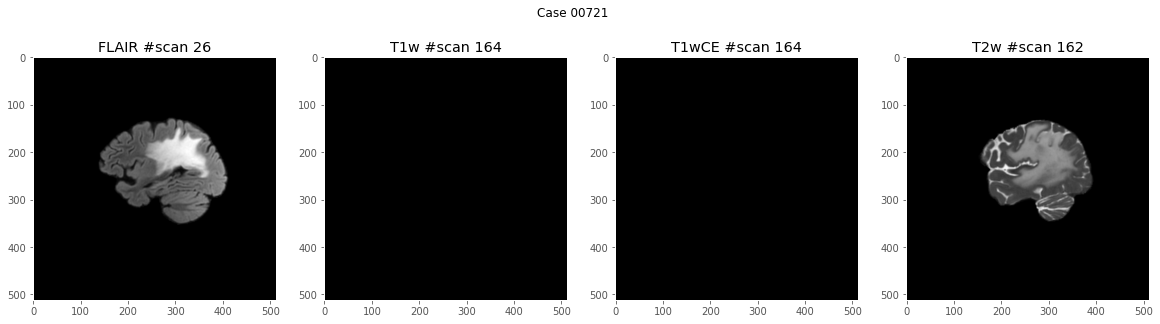

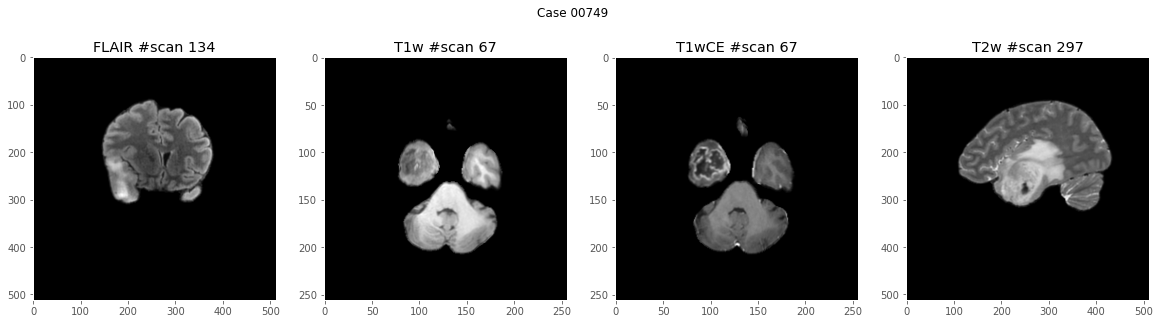

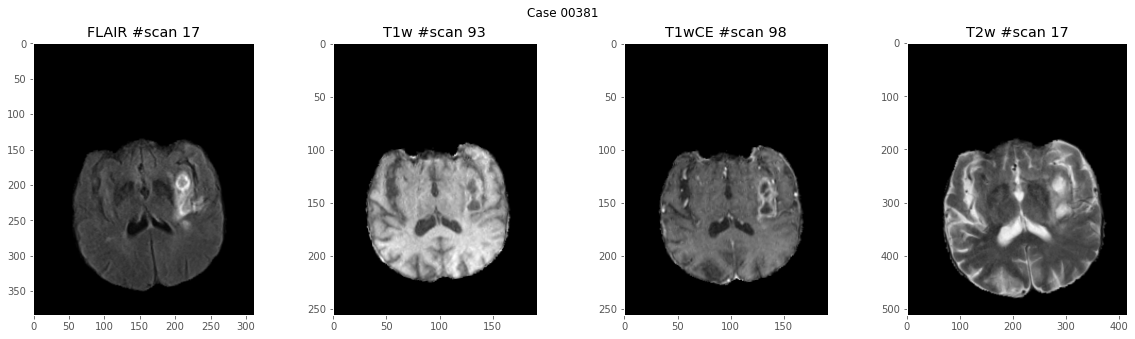

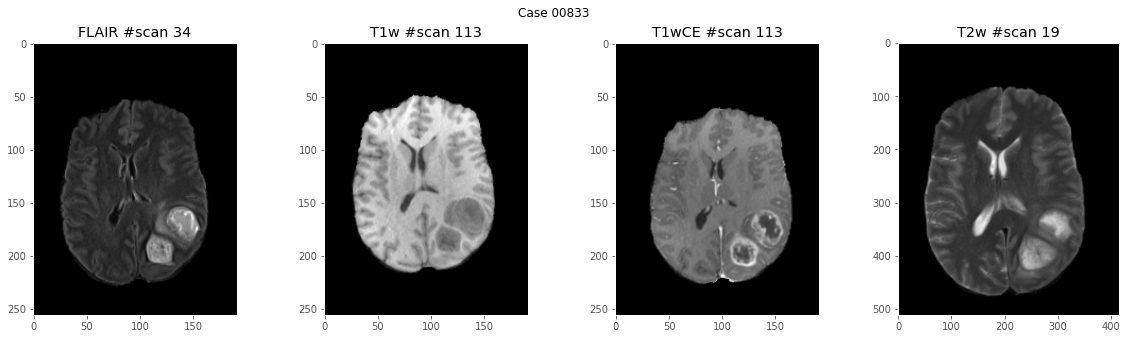

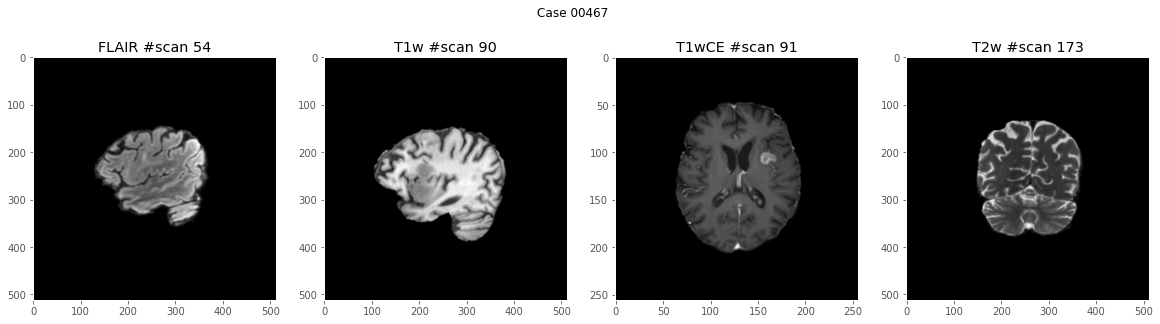

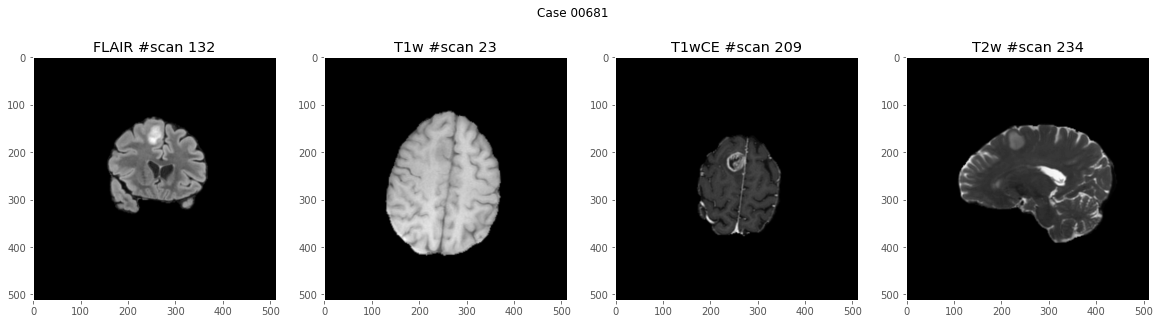

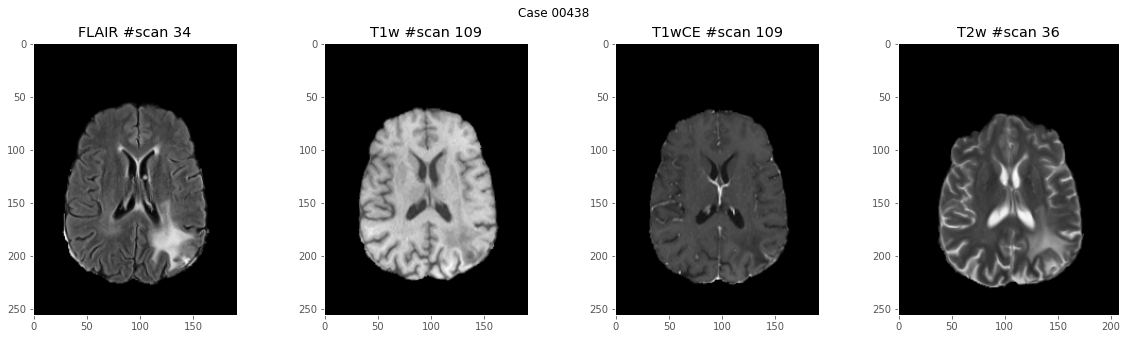

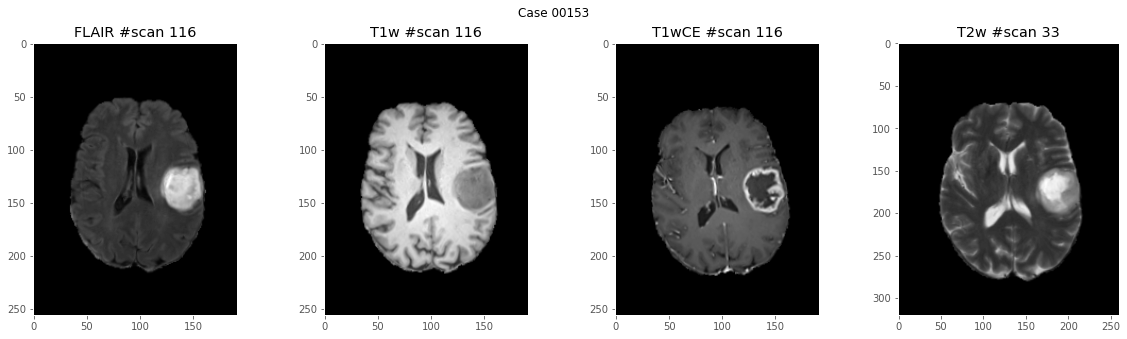

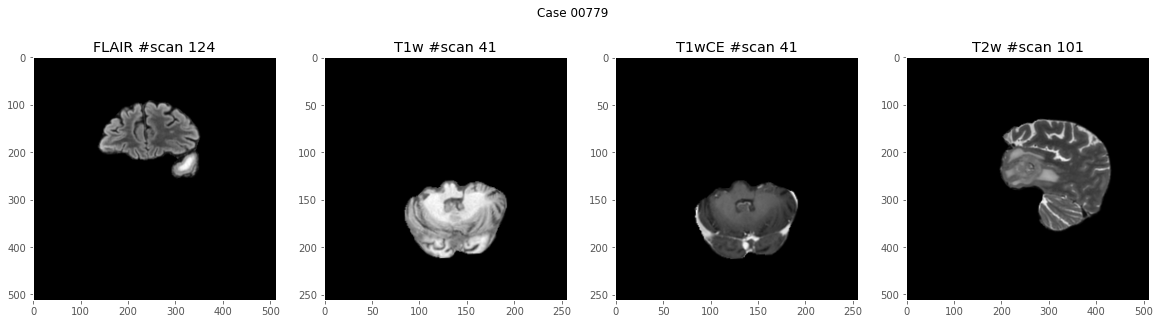

In [26]:
cohort = 'test'
for case in test.sample(10).BraTS21ID:
    process_case_and_plot(cohort, case)